In [12]:
# Imports, read and preview data

import pandas as pd
import matplotlib.pyplot as plt
import pickle

df = pd.read_csv("../data/tech_stock_prices.csv")
df.set_index("Timestamp", inplace=True)

print(f"Number of stocks: {df.shape[1]}\nNumber of timestamps: {df.shape[0]}")
print(df.iloc[:,:5].head())

Number of stocks: 511
Number of timestamps: 916
                            AAOI     AAPL   ACIW   ACLS    ACMR
Timestamp                                                      
2019-05-15 04:00:00+00:00  10.01  47.7300  31.25  17.15  7.1167
2019-05-16 04:00:00+00:00   9.71  47.5200  32.07  16.95  6.3133
2019-05-17 04:00:00+00:00   9.17  47.2500  31.42  16.50  6.4133
2019-05-20 04:00:00+00:00   9.27  45.7725  31.01  15.96  5.9100
2019-05-21 04:00:00+00:00   9.52  46.6500  31.51  16.34  6.0800


In [13]:
# Percentage of NaN values per ticker

nan_percentages = df.isna().mean()[1:] * 100
print(nan_percentages)

AAPL     0.000000
ACIW     0.000000
ACLS     0.000000
ACMR     0.000000
ADBE     0.000000
          ...    
YY       0.000000
ZENV    60.152838
ZI      29.039301
ZM       0.000000
ZS       0.000000
Length: 510, dtype: float64


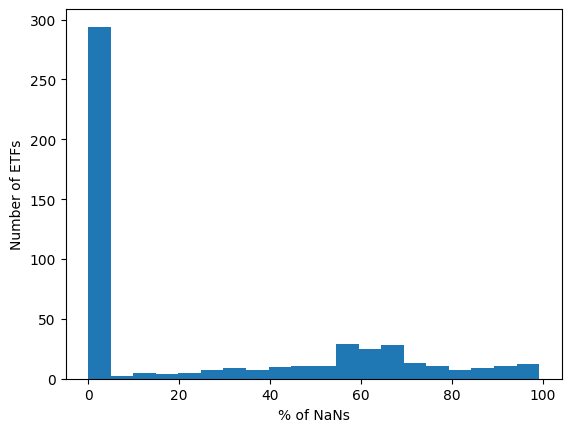

In [14]:
# Distribution of percentage of NaN values

plt.hist(nan_percentages, cumulative=False, bins=20)
plt.xlabel("% of NaNs")
plt.ylabel("Number of ETFs")
plt.show()

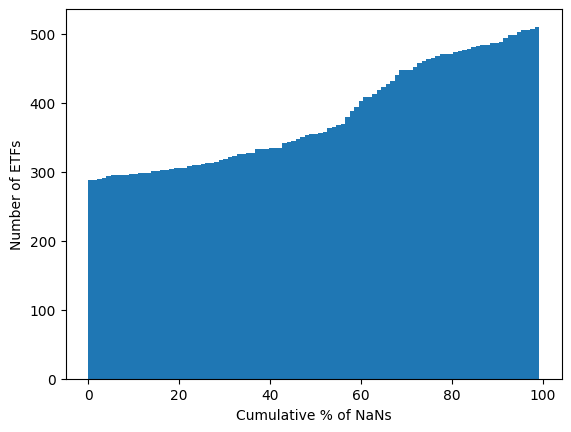

In [15]:
# Cumulative distribution of percentage of NaN values

plt.hist(nan_percentages, cumulative=True, bins=100)
plt.xlabel("Cumulative % of NaNs")
plt.ylabel("Number of ETFs")
plt.show()

In [16]:
# Drop series with more than 25% NaN values

valid_stocks = nan_percentages[nan_percentages == 0]
df = df[valid_stocks.index]

print(f"Number of valid stocks: {len(valid_stocks)}")

Number of valid stocks: 269


In [17]:
# Drop series if first or last value is NaN

valid_columns = df.columns[df.iloc[0].notna() & df.iloc[-1].notna()]
df = df[valid_columns]

print(f"Number of valid stocks: {len(valid_columns)}")

Number of valid stocks: 269


In [18]:
# Linear interpolation to impute NaN values

# df = df.apply(pd.to_numeric, errors='coerce')
# df.interpolate(method='linear', axis=0, inplace=True)

# print(df.head())

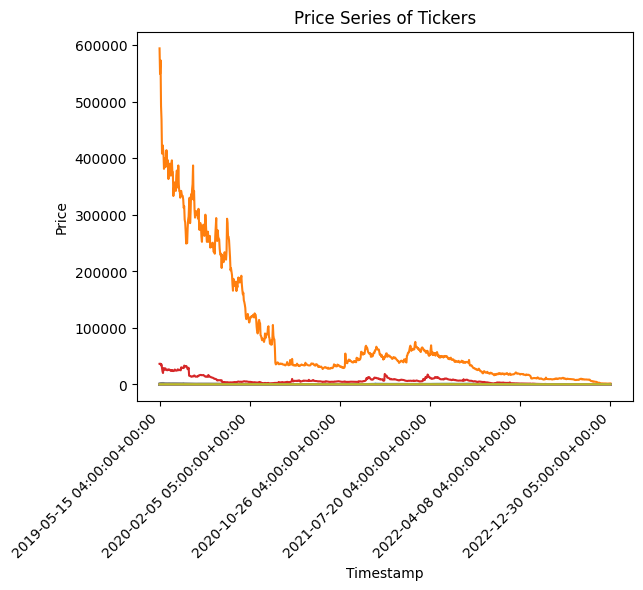

In [19]:
# Plot all remaining price series

for column in df.columns:
    plt.plot(df.index, df[column], label=column)

    # Add labels and legend
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.title('Price Series of Tickers')
num_ticks = 5  # Specify the number of ticks you want to display
plt.xticks(df.index[::len(df.index)//num_ticks])
plt.xticks(rotation=45, ha='right')
plt.show()

In [20]:
# Compute returns

df_returns = df.pct_change().iloc[1:]
print(df_returns.iloc[:,:5].head())

                               AAPL      ACIW      ACLS      ACMR      ADBE
Timestamp                                                                  
2019-05-16 04:00:00+00:00 -0.004400  0.026240 -0.011662 -0.112889  0.024312
2019-05-17 04:00:00+00:00 -0.005682 -0.020268 -0.026549  0.015840 -0.013049
2019-05-20 04:00:00+00:00 -0.031270 -0.013049 -0.032727 -0.078478 -0.015723
2019-05-21 04:00:00+00:00  0.019171  0.016124  0.023810  0.028765  0.009512
2019-05-22 04:00:00+00:00 -0.020472  0.016185 -0.012240 -0.041661  0.013486


In [21]:
# Save variables in a pickle file

with open('../data/experimental_ch0.pkl', 'wb') as f:
    pickle.dump([df, df_returns], f)

In [22]:
# Imports, read and preview data

import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import OPTICS
import numpy as np
from sklearn.manifold import TSNE
from collections import defaultdict
from itertools import combinations
import json
from scipy.stats import linregress
from statsmodels.tsa.stattools import adfuller
from hurst import compute_Hc
from statsmodels.regression.linear_model import OLS

with open('../data/experimental_ch0.pkl', 'rb') as f:
    df, df_returns = pickle.load(f)

In [23]:
# Apply PCA to returns data

pca = PCA(n_components=5, svd_solver='auto', random_state=42)
pca.fit(df_returns)
explained_variance = pca.explained_variance_ratio_

for i in range(len(explained_variance)):
    print(f"Variance explained by PC{i+1}: {explained_variance[i]:.2%}")

Variance explained by PC1: 24.65%
Variance explained by PC2: 16.77%
Variance explained by PC3: 4.47%
Variance explained by PC4: 2.66%
Variance explained by PC5: 2.27%


Means of PCs after scaling: [ 0.00578776 -0.05772135 -0.00136275 -0.00313186  0.00104397]


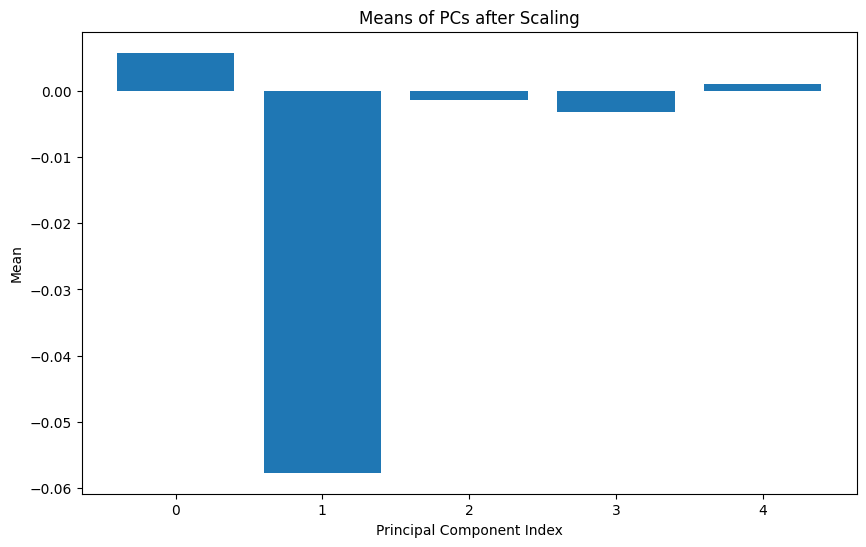

Standard deviations of PCs after scaling: [0.06069575 0.0196397  0.06095584 0.06089059 0.06096214]


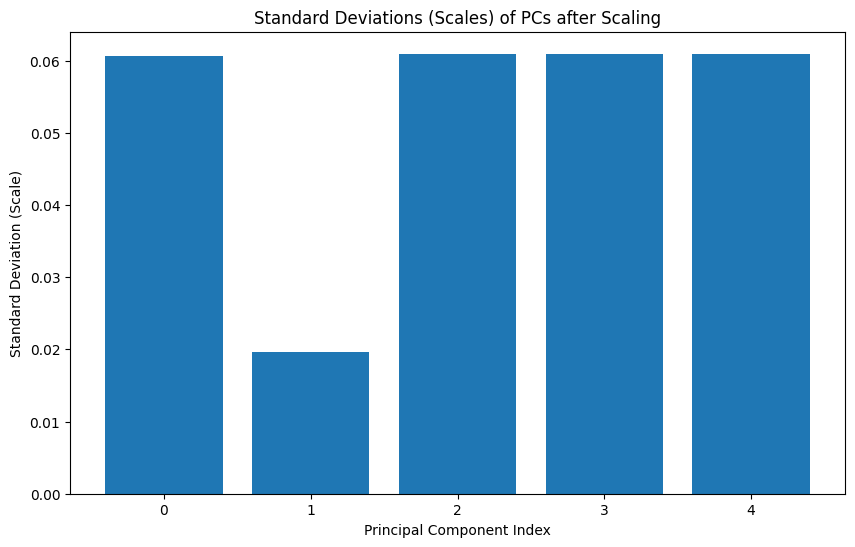

In [24]:
# Normalize PCA components using Standard Scaler

scaler = StandardScaler()
X = scaler.fit_transform(pca.components_.T)
print(f"Means of PCs after scaling: {scaler.mean_}")

plt.figure(figsize=(10, 6))
plt.bar(range(len(scaler.mean_)), scaler.mean_)
plt.title('Means of PCs after Scaling')
plt.xlabel('Principal Component Index')
plt.ylabel('Mean')
plt.show()

print(f"Standard deviations of PCs after scaling: {scaler.scale_}")

plt.figure(figsize=(10, 6))
plt.bar(range(len(scaler.scale_)), scaler.scale_)
plt.title('Standard Deviations (Scales) of PCs after Scaling')
plt.xlabel('Principal Component Index')
plt.ylabel('Standard Deviation (Scale)')
plt.show()

In [25]:
# Cluster PCs of returns using OPTICS

optics = OPTICS(min_samples=3, max_eps=5, xi=0.05, metric='euclidean', cluster_method='xi')
optics.fit(X)
labels = optics.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print("Number of clusters after OPTICS (excluding outliers): %d" % n_clusters_)

Number of clusters after OPTICS (excluding outliers): 30


In [26]:
# Assign clusters to ETFs

clustered_series_all = pd.Series(index=df_returns.columns, data=labels.flatten())
clustered_series = clustered_series_all[clustered_series_all != -1]

print(f"Number of ETFs assigned to a cluster: {len(clustered_series)}")

Number of ETFs assigned to a cluster: 128


In [27]:
# Compute cluster counts and pairs to evaluate

counts = clustered_series.value_counts()
counts.sort_index(inplace=True)
for i in counts.index:
    print(f"Cluster {i}: {counts[i]} ETFs")

print('Average cluster size: ', np.mean(counts))
print("Pairs to evaluate: %d" % (counts * (counts - 1) / 2).sum())

Cluster 0: 3 ETFs
Cluster 1: 7 ETFs
Cluster 2: 5 ETFs
Cluster 3: 4 ETFs
Cluster 4: 4 ETFs
Cluster 5: 4 ETFs
Cluster 6: 4 ETFs
Cluster 7: 3 ETFs
Cluster 8: 3 ETFs
Cluster 9: 3 ETFs
Cluster 10: 3 ETFs
Cluster 11: 4 ETFs
Cluster 12: 6 ETFs
Cluster 13: 7 ETFs
Cluster 14: 3 ETFs
Cluster 15: 3 ETFs
Cluster 16: 5 ETFs
Cluster 17: 4 ETFs
Cluster 18: 5 ETFs
Cluster 19: 3 ETFs
Cluster 20: 6 ETFs
Cluster 21: 3 ETFs
Cluster 22: 8 ETFs
Cluster 23: 6 ETFs
Cluster 24: 4 ETFs
Cluster 25: 3 ETFs
Cluster 26: 3 ETFs
Cluster 27: 4 ETFs
Cluster 28: 5 ETFs
Cluster 29: 3 ETFs
Average cluster size:  4.266666666666667
Pairs to evaluate: 239


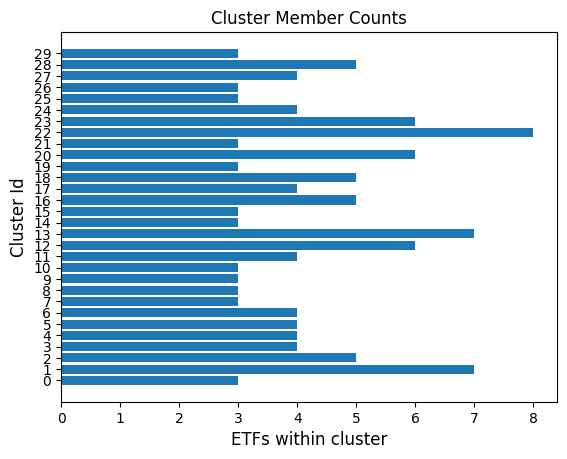

In [28]:
# Visualize cluster counts

plt.figure()
plt.barh(counts.index, counts.values)
plt.title('Cluster Member Counts')
plt.yticks(np.arange(0, len(counts), 1))
plt.xlabel('ETFs within cluster', size=12)
plt.ylabel('Cluster Id', size=12);

In [29]:
# Fit scaled PCs to 2d t-SNE for visualization

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X)

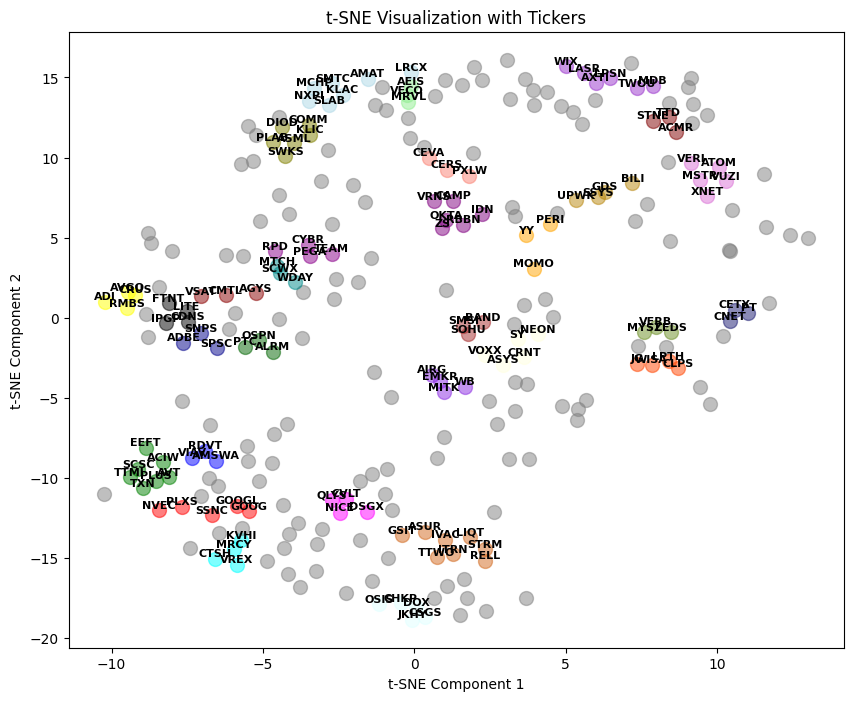

In [32]:
# Plot 2d t-SNE visualization with cluster labels

plt.figure(figsize=(10, 8))

colors = ['gray', 'blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 
               'darkblue', 'darkgreen', 'darkred', 
               'darkcyan', 'darkmagenta', 'olive',
               'lightblue', 'lightgreen', 'salmon', 'lightcyan', 
               'blueviolet', 'lightyellow', 
               'orange', 'purple', 'brown', 'chocolate', 'darkorchid', 'darkgoldenrod', 'maroon', 'olivedrab', 'orangered', 'orchid', 'midnightblue']
for i in range(len(X_tsne)):
    plt.scatter(X_tsne[i, 0], X_tsne[i, 1], color=colors[labels[i] + 1], alpha=0.5, s=100)
    if labels[i] == -1:
        continue
    plt.text(X_tsne[i, 0], X_tsne[i, 1], df_returns.columns[i], fontsize=8, fontweight='bold', horizontalalignment='center', verticalalignment='bottom')
plt.title('t-SNE Visualization with Tickers')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

plt.show()

In [33]:
# Fit scaled PCs to 3d t-SNE for visualization

tsne = TSNE(n_components=3, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X)

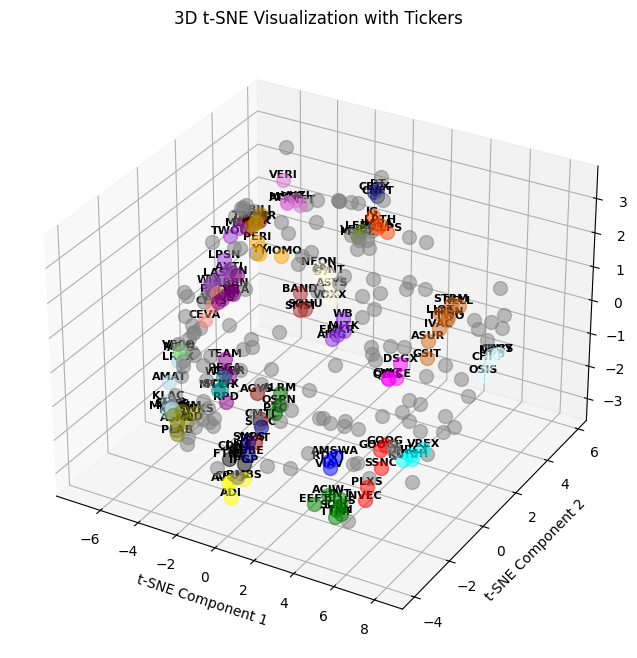

In [34]:
# Plot 3d t-SNE visualization with cluster labels

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
colors = ['gray', 'blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 
               'darkblue', 'darkgreen', 'darkred', 
               'darkcyan', 'darkmagenta', 'olive',
               'lightblue', 'lightgreen', 'salmon', 'lightcyan', 
               'blueviolet', 'lightyellow', 
               'orange', 'purple', 'brown', 'chocolate', 'darkorchid', 'darkgoldenrod', 'maroon', 'olivedrab', 'orangered', 'orchid', 'midnightblue']
for i in range(len(X_tsne)):
    ax.scatter(X_tsne[i, 0], X_tsne[i, 1], X_tsne[i, 2], color=colors[labels[i] + 1], alpha=0.5, s=100)
    if labels[i] == -1:
        continue
    ax.text(X_tsne[i, 0], X_tsne[i, 1], X_tsne[i, 2], df_returns.columns[i], fontsize=8, fontweight='bold', horizontalalignment='center', verticalalignment='bottom')
ax.set_title('3D t-SNE Visualization with Tickers')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')

plt.show()

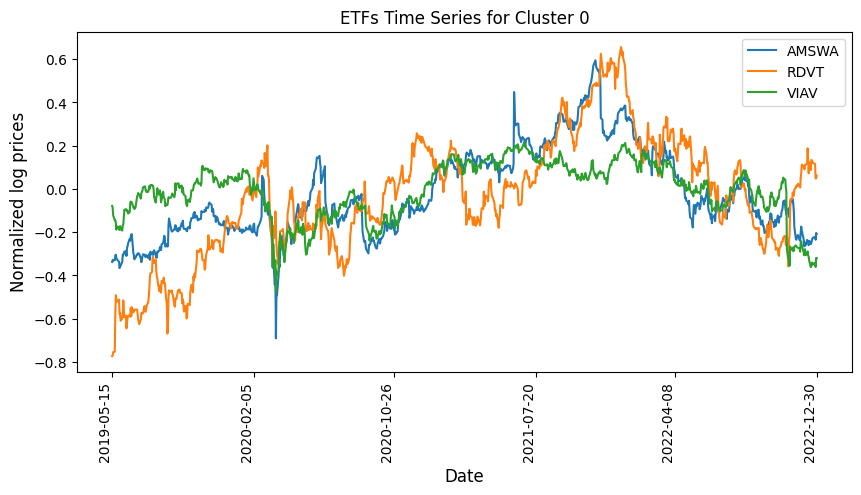

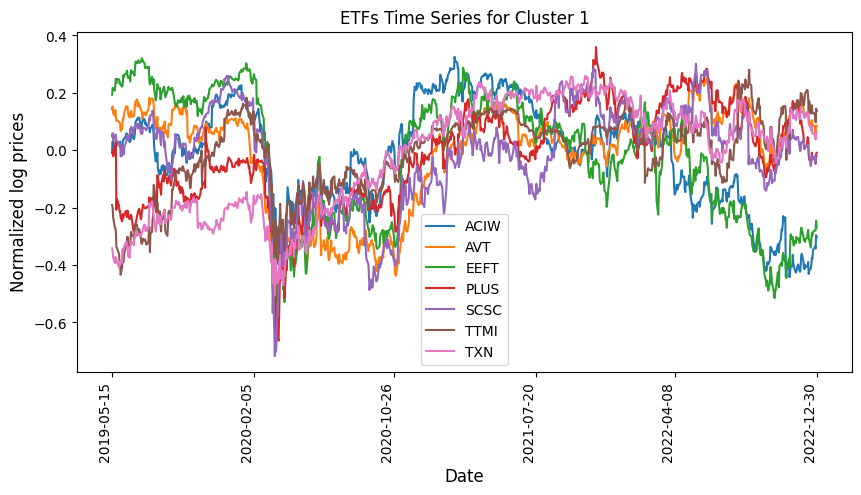

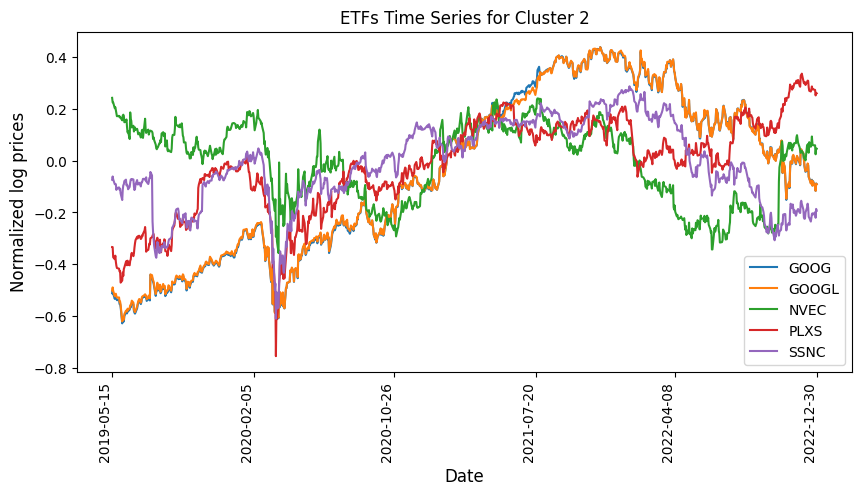

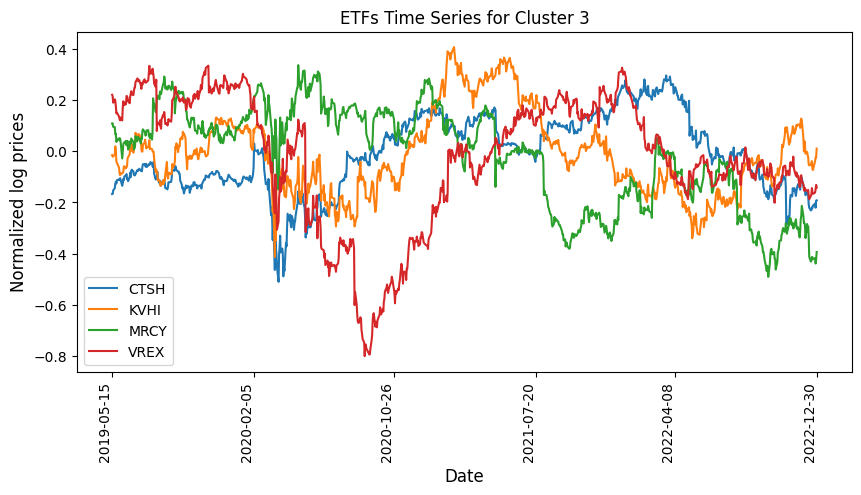

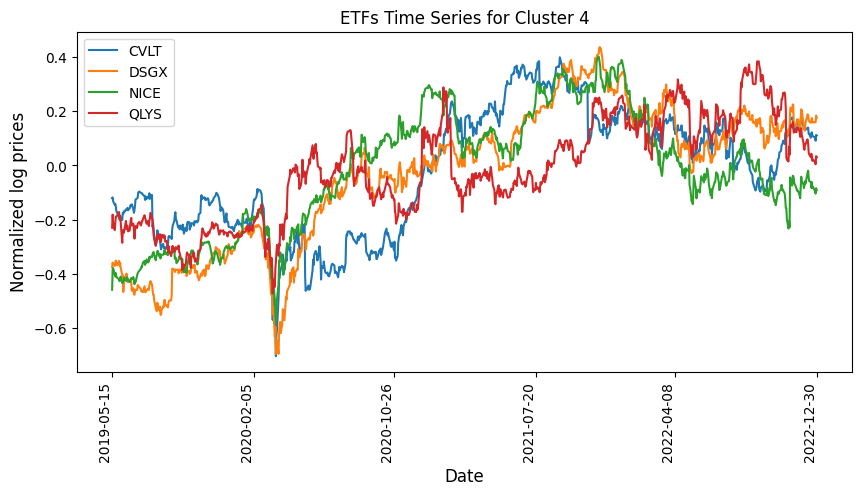

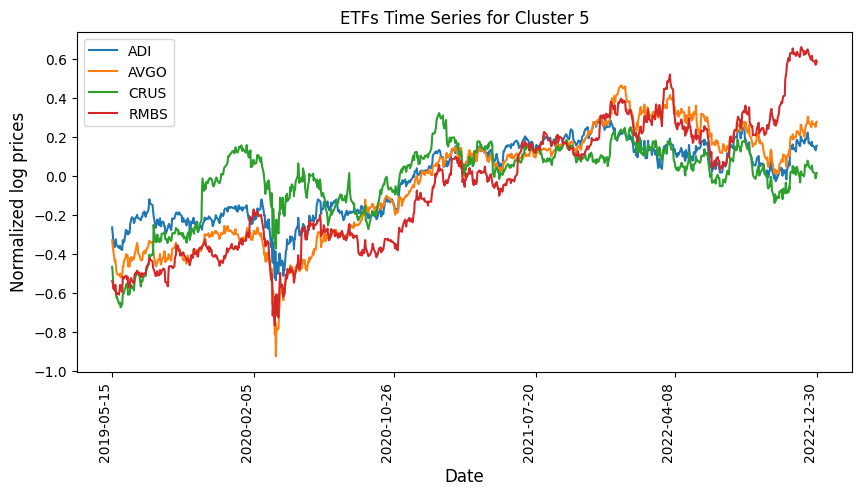

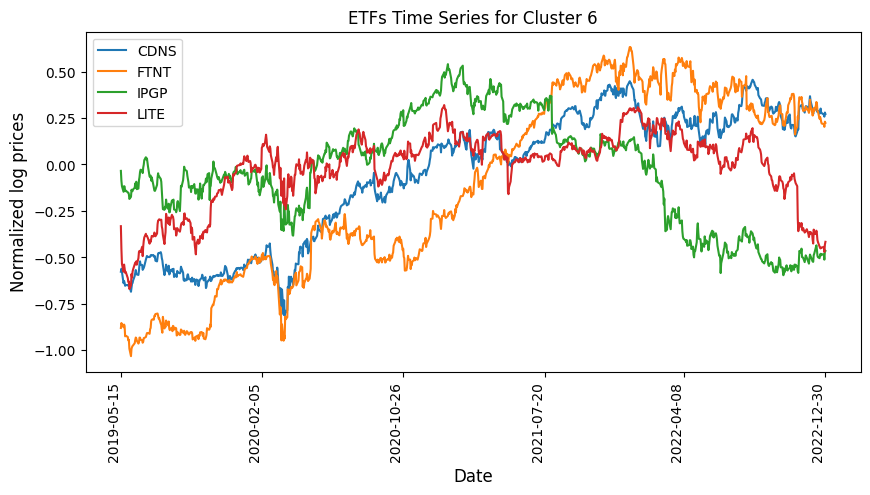

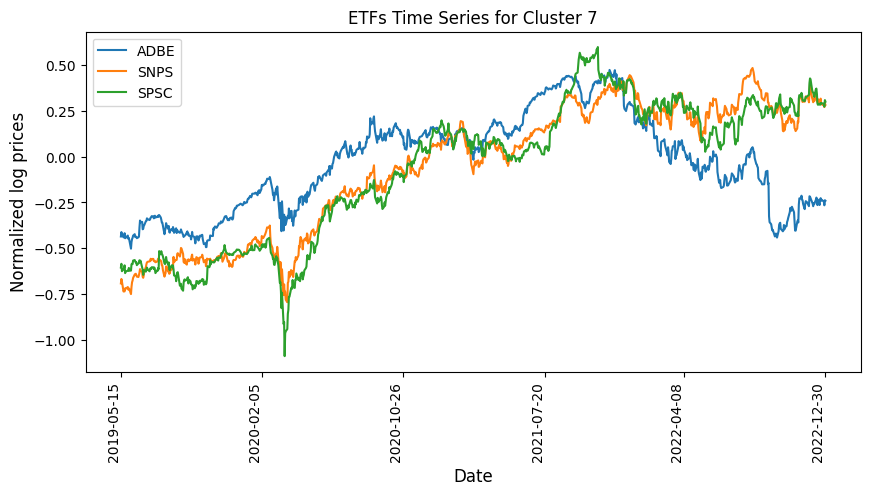

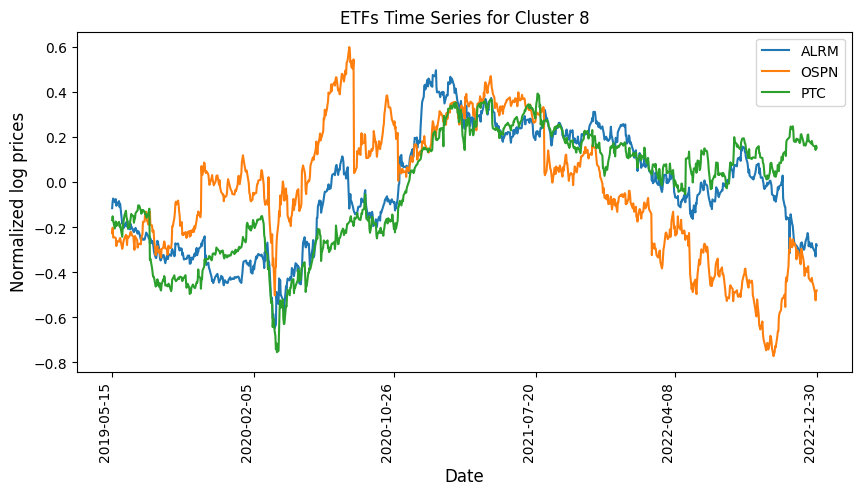

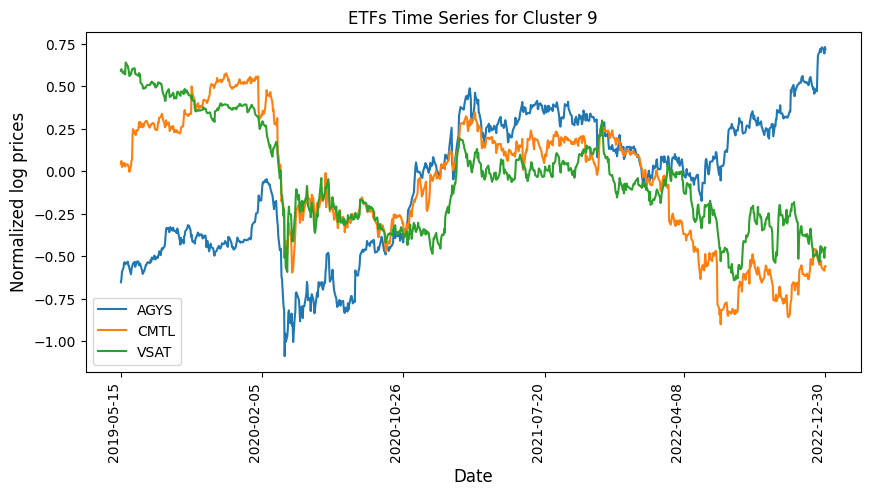

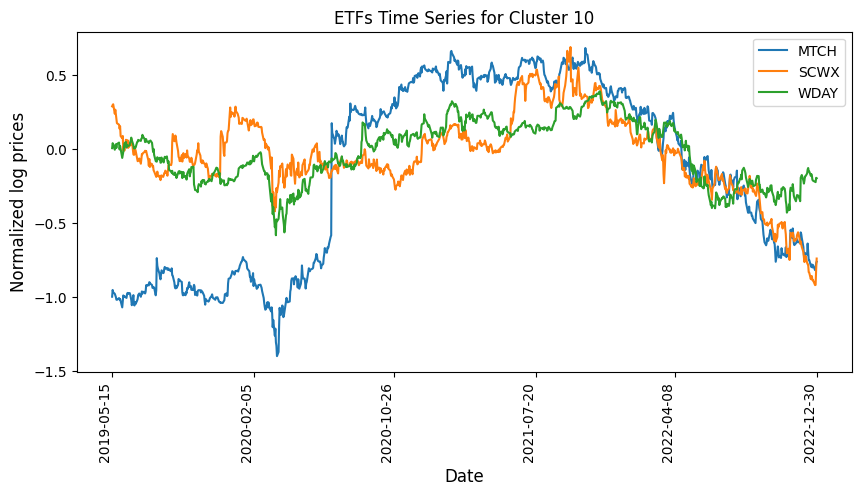

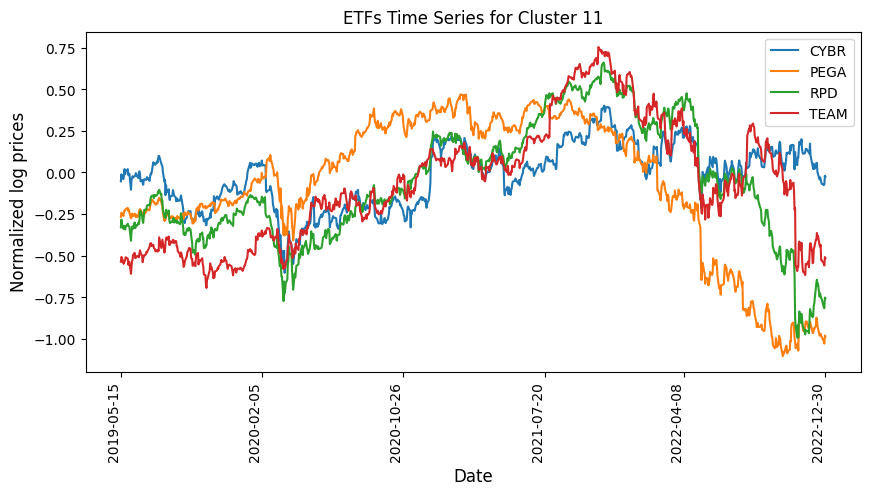

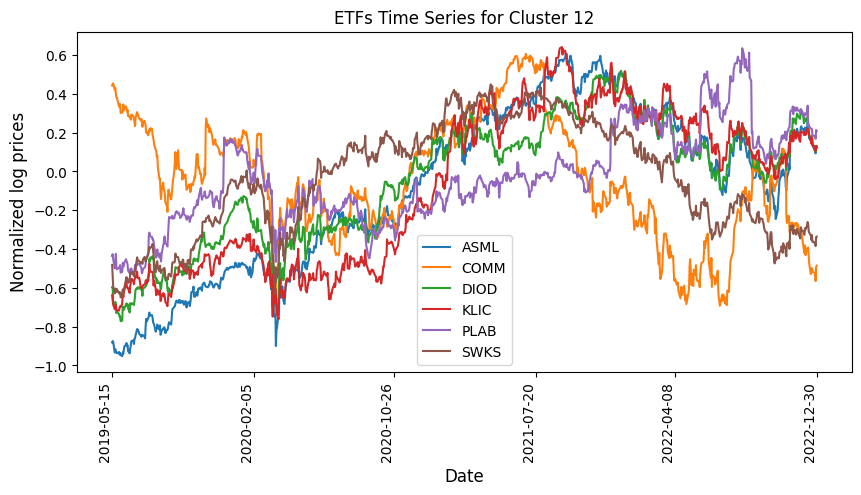

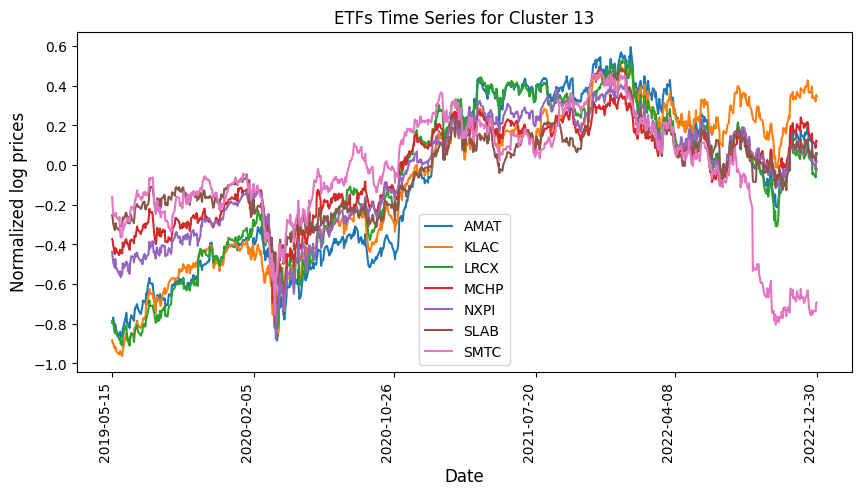

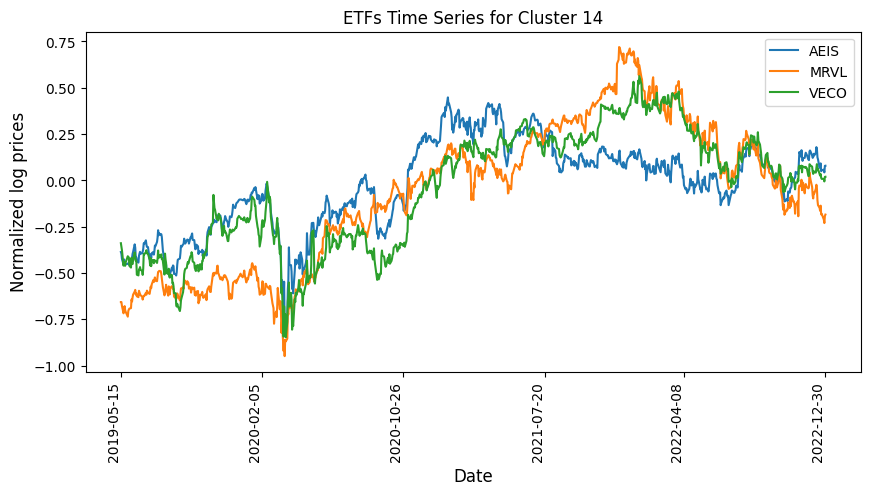

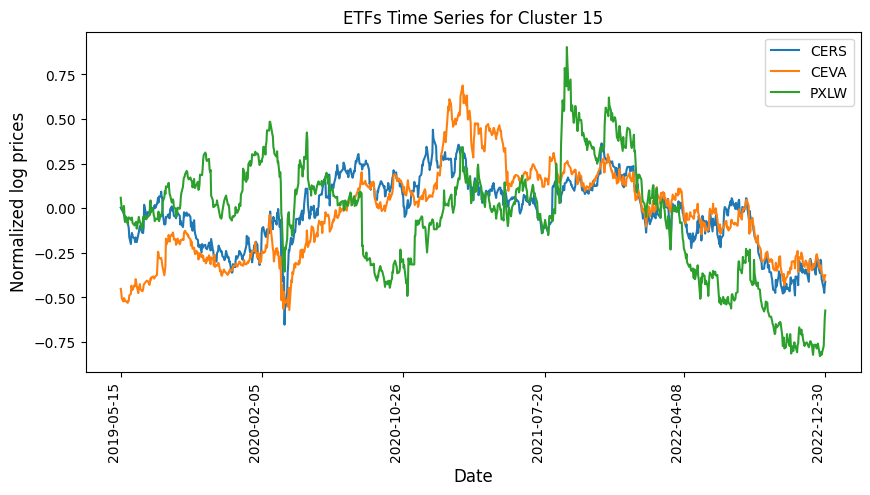

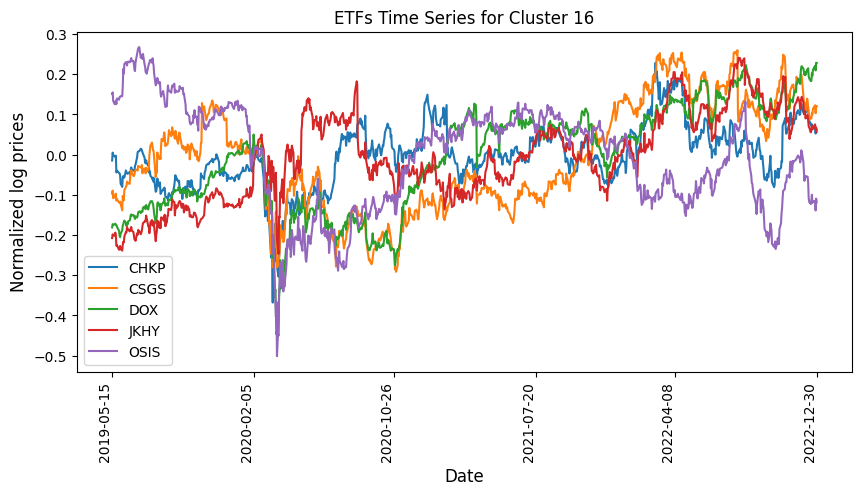

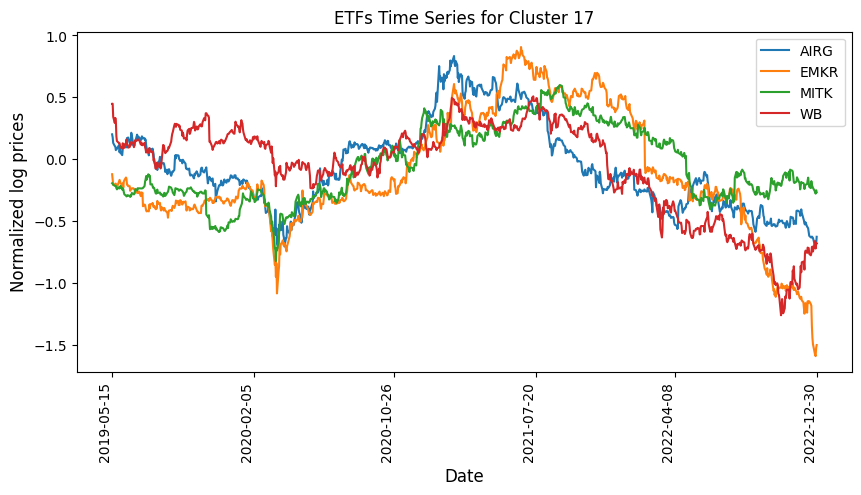

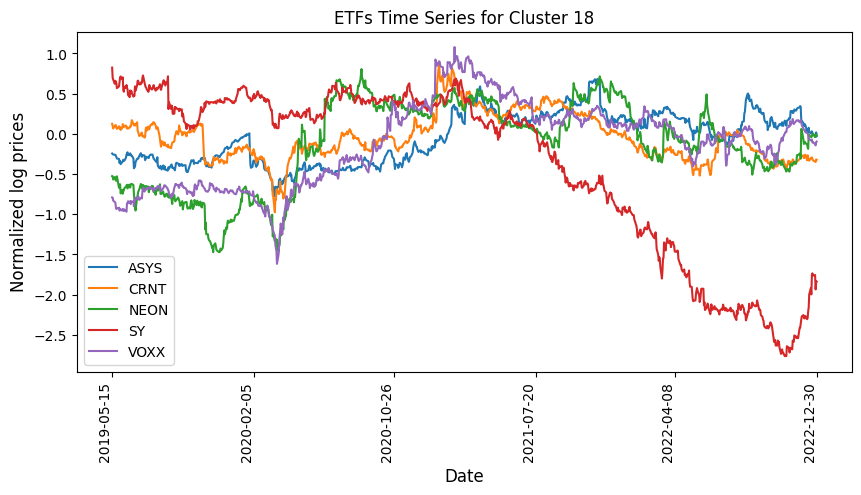

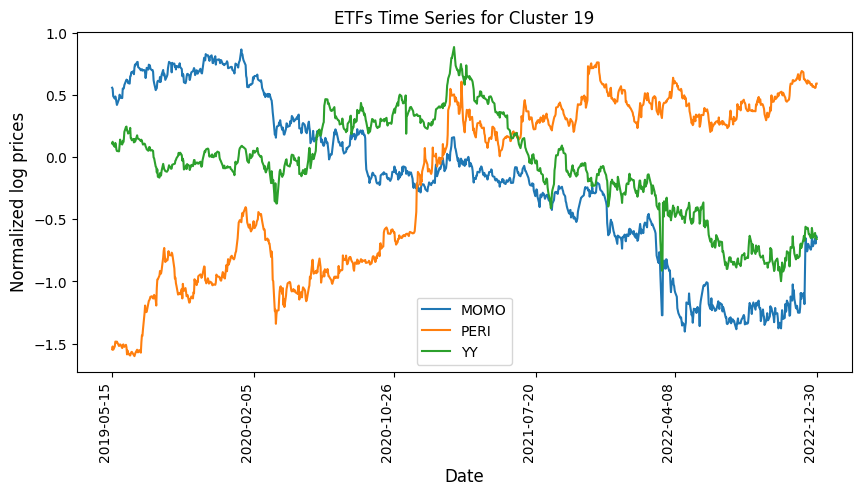

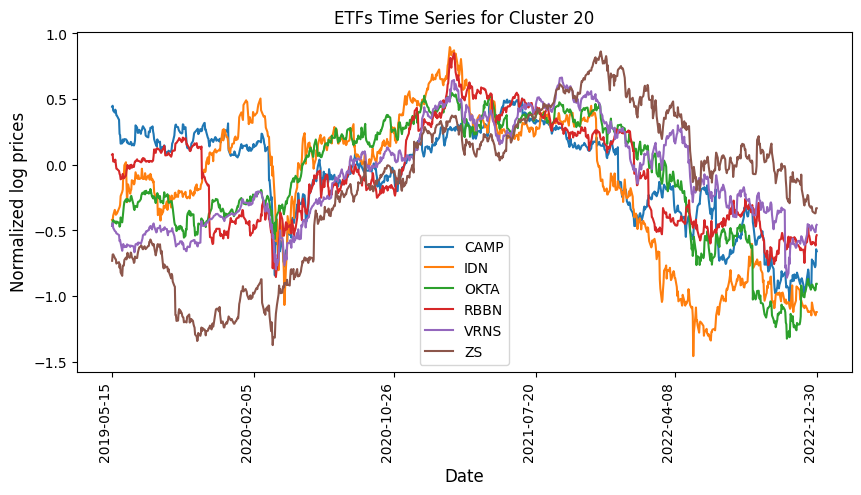

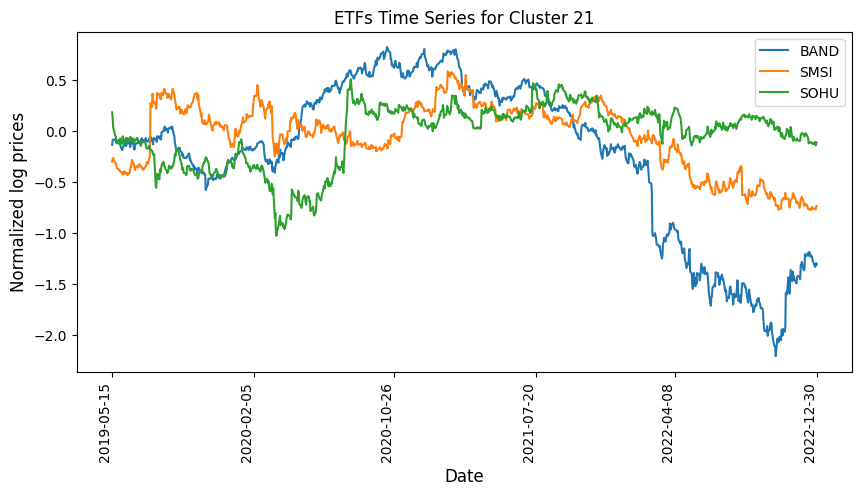

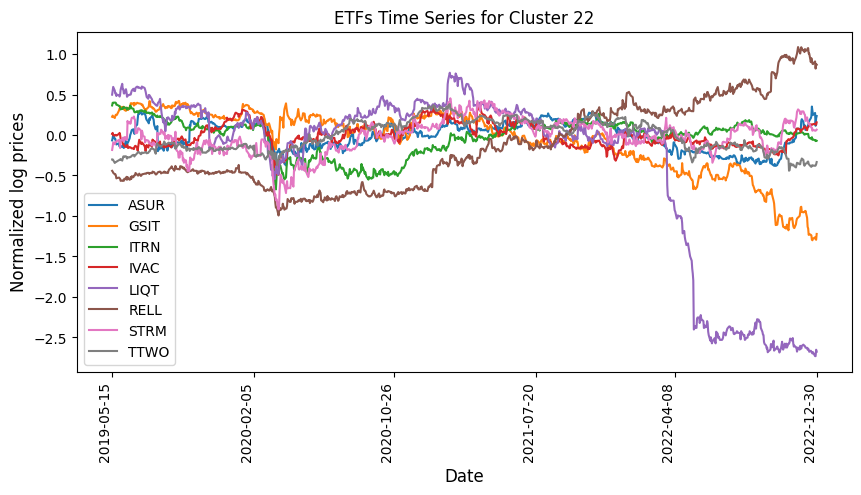

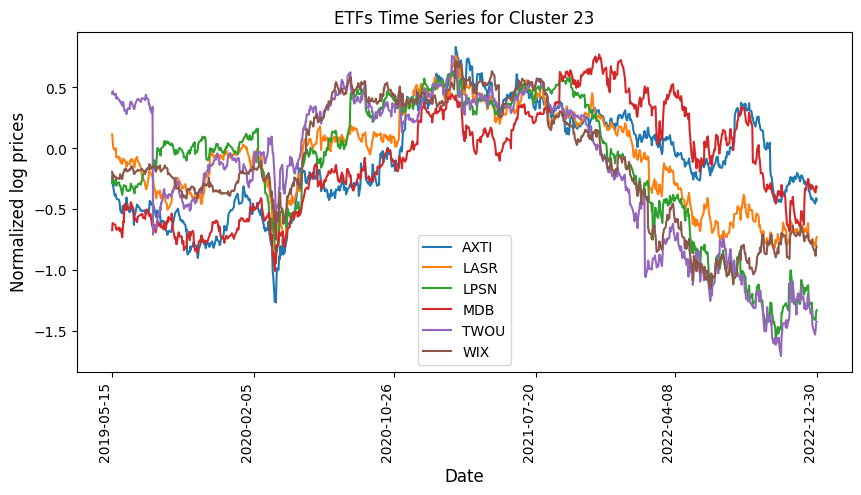

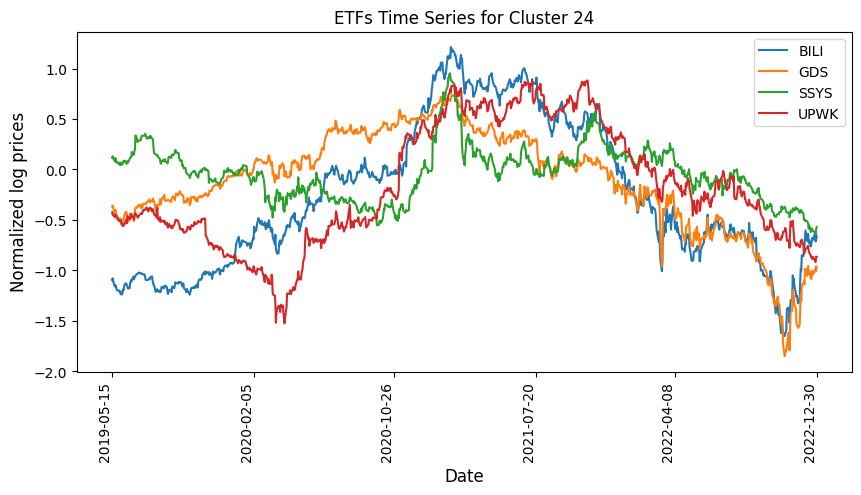

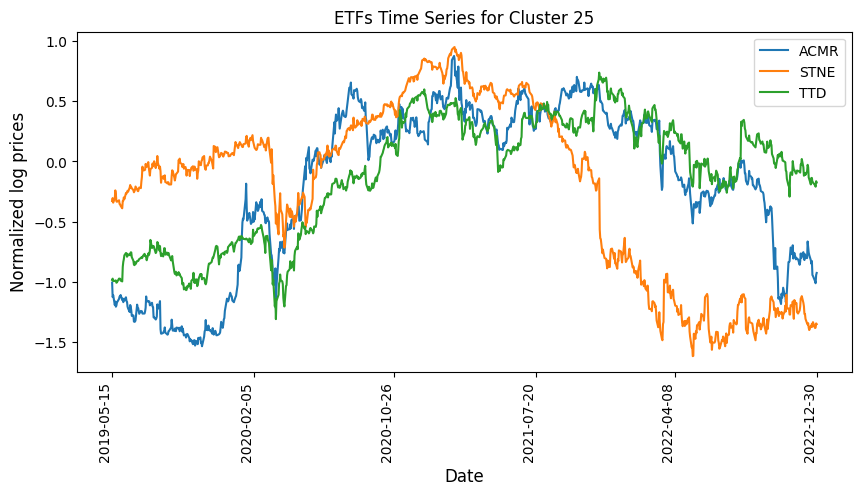

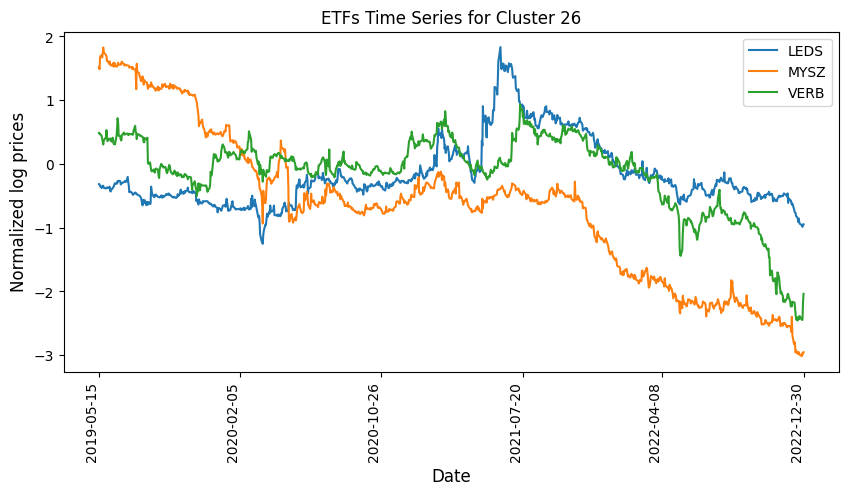

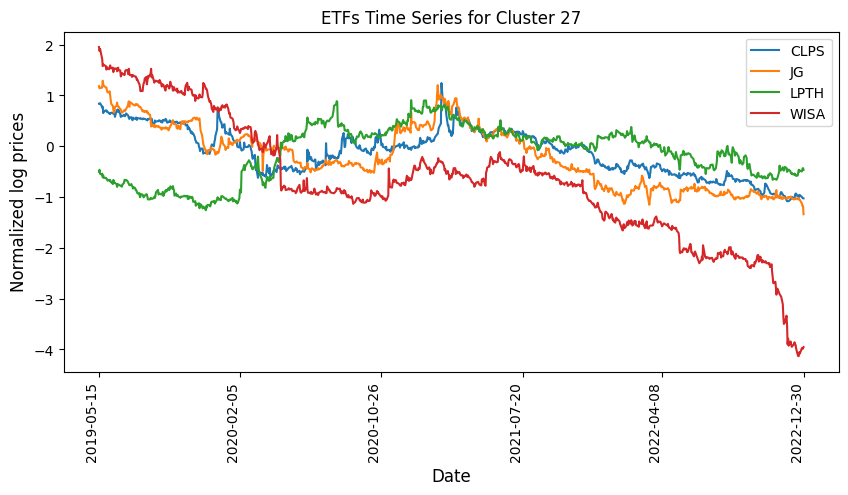

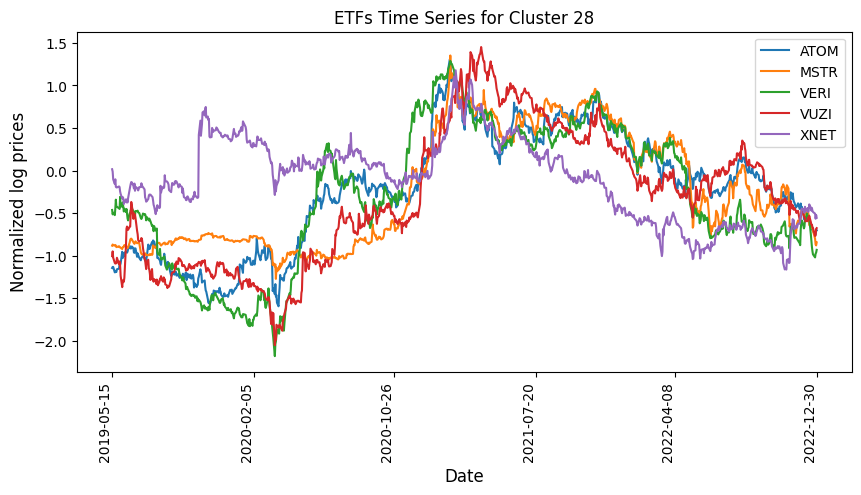

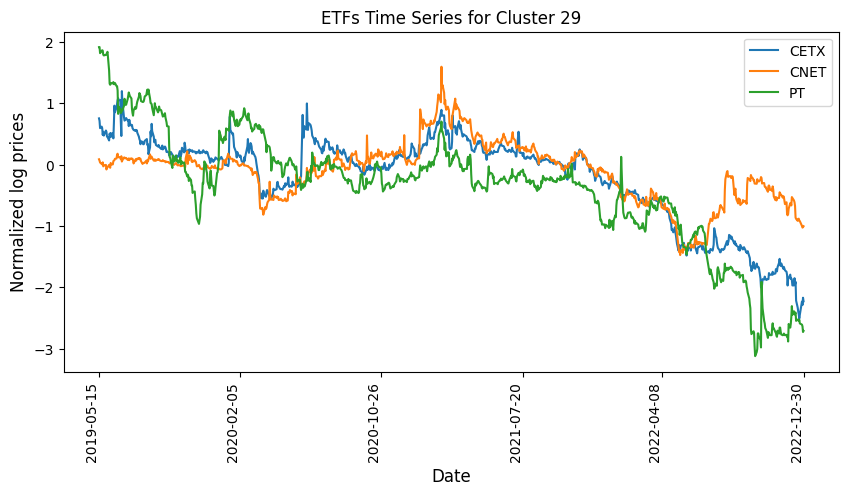

In [36]:
# Visualize price series for all clusters

for cluster in range(len(counts)):
    symbols = list(clustered_series[clustered_series==cluster].index)
    means = np.log(df[symbols].mean())
    series = np.log(df[symbols]).sub(means)
    series.plot(figsize=(10,5), title='ETFs Time Series for Cluster %d' % (cluster))
    plt.ylabel('Normalized log prices', size=12)
    plt.xlabel('Date', size=12)
    num_ticks = 5
    df.index = pd.to_datetime(df.index)
    plt.xticks(df.index[::len(df.index)//num_ticks])
    plt.xticks(rotation=90, ha='right')
    plt.show()

In [37]:
# Compute clusters and tickers

cluster_dict = defaultdict(list)
pairs_dict = defaultdict(list)
pairs_to_eval = []

for i in range(len(clustered_series)):
    cluster_dict[int(clustered_series.iloc[i])].append(clustered_series.index[i])

print(f"Clusters and their tickers:\n{json.dumps(cluster_dict, indent=4)}")

Clusters and their tickers:
{
    "1": [
        "ACIW",
        "AVT",
        "EEFT",
        "PLUS",
        "SCSC",
        "TTMI",
        "TXN"
    ],
    "25": [
        "ACMR",
        "STNE",
        "TTD"
    ],
    "7": [
        "ADBE",
        "SNPS",
        "SPSC"
    ],
    "5": [
        "ADI",
        "AVGO",
        "CRUS",
        "RMBS"
    ],
    "14": [
        "AEIS",
        "MRVL",
        "VECO"
    ],
    "9": [
        "AGYS",
        "CMTL",
        "VSAT"
    ],
    "17": [
        "AIRG",
        "EMKR",
        "MITK",
        "WB"
    ],
    "8": [
        "ALRM",
        "OSPN",
        "PTC"
    ],
    "13": [
        "AMAT",
        "KLAC",
        "LRCX",
        "MCHP",
        "NXPI",
        "SLAB",
        "SMTC"
    ],
    "0": [
        "AMSWA",
        "RDVT",
        "VIAV"
    ],
    "12": [
        "ASML",
        "COMM",
        "DIOD",
        "KLIC",
        "PLAB",
        "SWKS"
    ],
    "22": [
        "ASUR",
        "GSIT",
    

In [38]:
# Compute pairs in each cluster

for k, v in cluster_dict.items():
    pair_combinations = list(combinations(v, 2))
    pairs_dict[k] = pair_combinations

print(f"Pairs in each cluster:\n{json.dumps(pairs_dict, indent=4)}")

Pairs in each cluster:
{
    "1": [
        [
            "ACIW",
            "AVT"
        ],
        [
            "ACIW",
            "EEFT"
        ],
        [
            "ACIW",
            "PLUS"
        ],
        [
            "ACIW",
            "SCSC"
        ],
        [
            "ACIW",
            "TTMI"
        ],
        [
            "ACIW",
            "TXN"
        ],
        [
            "AVT",
            "EEFT"
        ],
        [
            "AVT",
            "PLUS"
        ],
        [
            "AVT",
            "SCSC"
        ],
        [
            "AVT",
            "TTMI"
        ],
        [
            "AVT",
            "TXN"
        ],
        [
            "EEFT",
            "PLUS"
        ],
        [
            "EEFT",
            "SCSC"
        ],
        [
            "EEFT",
            "TTMI"
        ],
        [
            "EEFT",
            "TXN"
        ],
        [
            "PLUS",
            "SCSC"
        ],
        [
   

In [39]:
# Compile all pairs in a single list

for k, v in pairs_dict.items():
    pairs_to_eval += pairs_dict[k]

print("All pair combinations:")
for i in pairs_to_eval:
    print(f"{i[0]} <--> {i[1]}")

All pair combinations:
ACIW <--> AVT
ACIW <--> EEFT
ACIW <--> PLUS
ACIW <--> SCSC
ACIW <--> TTMI
ACIW <--> TXN
AVT <--> EEFT
AVT <--> PLUS
AVT <--> SCSC
AVT <--> TTMI
AVT <--> TXN
EEFT <--> PLUS
EEFT <--> SCSC
EEFT <--> TTMI
EEFT <--> TXN
PLUS <--> SCSC
PLUS <--> TTMI
PLUS <--> TXN
SCSC <--> TTMI
SCSC <--> TXN
TTMI <--> TXN
ACMR <--> STNE
ACMR <--> TTD
STNE <--> TTD
ADBE <--> SNPS
ADBE <--> SPSC
SNPS <--> SPSC
ADI <--> AVGO
ADI <--> CRUS
ADI <--> RMBS
AVGO <--> CRUS
AVGO <--> RMBS
CRUS <--> RMBS
AEIS <--> MRVL
AEIS <--> VECO
MRVL <--> VECO
AGYS <--> CMTL
AGYS <--> VSAT
CMTL <--> VSAT
AIRG <--> EMKR
AIRG <--> MITK
AIRG <--> WB
EMKR <--> MITK
EMKR <--> WB
MITK <--> WB
ALRM <--> OSPN
ALRM <--> PTC
OSPN <--> PTC
AMAT <--> KLAC
AMAT <--> LRCX
AMAT <--> MCHP
AMAT <--> NXPI
AMAT <--> SLAB
AMAT <--> SMTC
KLAC <--> LRCX
KLAC <--> MCHP
KLAC <--> NXPI
KLAC <--> SLAB
KLAC <--> SMTC
LRCX <--> MCHP
LRCX <--> NXPI
LRCX <--> SLAB
LRCX <--> SMTC
MCHP <--> NXPI
MCHP <--> SLAB
MCHP <--> SMTC
NXPI <--> SL

In [40]:
criteria_valid_pairs = pairs_to_eval.copy()

cointegration_p_val_threshold = 0.1 # Assumed to be cointegrated if smaller than 0.05
hurst_exponent_threshold = 0.5 # Assumed to be mean reverting if smaller than 0.5
half_life_threshold = 260 # Assumed to revert to mean in maximum 1 year (260 working days) if smaller than 260
mean_crosses_threshold = 48 # Assumed to revert to mean 48 times in 4 years (on average once every month) if greater than 48

for pair in pairs_to_eval:

    price_series_1 = df[pair[0]]
    price_series_2 = df[pair[1]]

    # Check for cointegration using ADF test

    slope, intercept, _, _, _ = linregress(price_series_1, price_series_2)
    residuals = price_series_2 - (slope * price_series_1 + intercept)
    cointegration_result = adfuller(residuals, autolag='AIC')

    # Check for mean reversion using Hurst exponent

    H_val, _, _ = compute_Hc(residuals)

    # Check for stationarity using half-life of mean-reverting process

    lagged_residuals = np.roll(residuals, 1)
    lagged_residuals[0] = 0
    delta_residuals = residuals - lagged_residuals
    lagged_residuals_with_intercept = np.vstack([lagged_residuals, np.ones(len(lagged_residuals))]).T
    model = OLS(delta_residuals, lagged_residuals_with_intercept).fit()
    half_life = -np.log(2) / model.params.iloc[0]

    # Check for mean reversion frequency using mean crossings

    delta_residuals_mean = residuals - np.mean(residuals)
    mean_crossings = sum(1 for i, _ in enumerate(delta_residuals_mean) if (i + 1 < len(delta_residuals_mean)) if ((delta_residuals_mean.iloc[i] * delta_residuals_mean.iloc[i + 1] < 0) or (delta_residuals_mean.iloc[i] == 0)))

    # Compute valid pairs that satisfy all criteria. remove remaining pairs

    if cointegration_result[1] < cointegration_p_val_threshold and H_val < hurst_exponent_threshold and half_life < half_life_threshold and mean_crossings > mean_crosses_threshold:
        print(f"{pair[0]} and {pair[1]} are a valid pair.")
    else:
        criteria_valid_pairs.remove(pair)
    
print(f"Found {len(criteria_valid_pairs)} valid pairs in total.")

with open('../data/ch1_valid_pairs.pkl', 'wb') as f:
    pickle.dump(criteria_valid_pairs, f)

AVT and SCSC are a valid pair.
PLUS and TTMI are a valid pair.
SNPS and SPSC are a valid pair.
ADI and AVGO are a valid pair.
MRVL and VECO are a valid pair.
AMAT and MCHP are a valid pair.
AMAT and NXPI are a valid pair.
AMAT and SLAB are a valid pair.
KLAC and MCHP are a valid pair.
LRCX and MCHP are a valid pair.
LRCX and NXPI are a valid pair.
MCHP and NXPI are a valid pair.
ASML and KLIC are a valid pair.
ASUR and IVAC are a valid pair.
ASUR and STRM are a valid pair.
GSIT and IVAC are a valid pair.
GSIT and RELL are a valid pair.
GSIT and STRM are a valid pair.
IVAC and STRM are a valid pair.
LIQT and STRM are a valid pair.
RELL and STRM are a valid pair.
ATOM and MSTR are a valid pair.
ATOM and VERI are a valid pair.
MSTR and VERI are a valid pair.
AXTI and MDB are a valid pair.
LASR and LPSN are a valid pair.
LASR and TWOU are a valid pair.
TWOU and WIX are a valid pair.
CERS and CEVA are a valid pair.
CERS and PXLW are a valid pair.
CSGS and JKHY are a valid pair.
JKHY and OSI